# Moving Average Crossover Trading Strategy for First Trust NASDAQ Clean Edge Green Energy Index Fund (QCLN)

Overview:
This notebook downloads then analyses data on the First Trust NASDAQ Clean Edge Green Energy Index Fund to determine if this fund's exponential moving average with a lag of 20 days has crossed the exponential moving average with a lag of 100 days in the past trading day. If so, the python script then retrieves an email list stored on the user's computer and sends the email recipients an email message to either invest or divest from the index fund depending on the direction that the 20 day exponential moving average crossed the 100 day moving average. 

In [16]:
# import packages

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import smtplib
import os
from email.message import EmailMessage
import imghdr
import warnings
from pandas.plotting import register_matplotlib_converters

In [17]:
# dowlownd one year of data on First Trust NASDAQ Clean Edge Green Energy 
#Index Fund (QCLN) from Yahoo Finance
qcln = yf.Ticker("QCLN")
period = '1y'
data = qcln.history(period= period)
df = data[['Close']]

In [18]:
# calculate two exponential moving averages with a lag of 20
#days and 100 days based on closing prices
ewm_20d = df.Close.ewm(span=20, adjust= False).mean().to_frame()
ewm_100d = df.Close.ewm(span = 100, adjust = False).mean().to_frame()

In [19]:
# determine where the 20 day moving average has crossed the 100 day moving 
#average in the past day
ewm_20d_2days = ewm_20d.iloc[-2:,:]
ewm_100d_2days = ewm_100d.iloc[-2:,:]

prev_ewm20d_2days = ewm_20d_2days['Close'].shift(1)
prev_ewm100d_2days = ewm_100d_2days['Close'].shift(1)


crossings_ewm_2days = (((ewm_20d_2days['Close'] <= ewm_100d_2days['Close']) & (prev_ewm20d_2days >= prev_ewm100d_2days))
            | ((ewm_20d_2days['Close'] >= ewm_100d_2days['Close']) & (prev_ewm20d_2days <= prev_ewm100d_2days)))

In [20]:
# determine if the 20 day exponential moving average has crossed the 
#100 day moving average in the last trading day
# if so a graph of the two exponential moving average of the past 
#year will be sent to investors along with a message telling investors
# to invest or divest depending on the direction that the 20 day moving
# aveage crossed to 100 day moving average.

warnings.filterwarnings("ignore")
%matplotlib inline

if crossings_ewm_2days.any() == True:    
    
    prev_ewm20d = ewm_20d['Close'].shift(1)
    prev_ewm100d = ewm_100d['Close'].shift(1)

    crossings_ewm = (((ewm_20d['Close'] <= ewm_100d['Close']) & (prev_ewm20d >= prev_ewm100d))
            | ((ewm_20d['Close'] >= ewm_100d['Close']) & (prev_ewm20d <= prev_ewm100d)))
    

# join sma_20d and stockp2 on index
    ewm20d_ewm100d = ewm_20d.join(ewm_100d, lsuffix='20dayEWM', rsuffix='100dayEWM')

# add a buy sell column based on the direction in which the stock price
#crossed the moving average
    crossing_dates = ewm20d_ewm100d[crossings_ewm]
    crossing_dates['switch_sign'] = crossing_dates['Close20dayEWM'] - crossing_dates['Close100dayEWM']
    crossing_dates['buyorsell'] = np.where(crossing_dates['switch_sign'] > 0, 'buy', 'sell')

    buyewm_symbol = crossing_dates['buyorsell'] == 'buy'
    sellewm_symbol = crossing_dates['buyorsell'] == 'sell'

    buyewm_series = crossing_dates[buyewm_symbol]
    sellewm_series =crossing_dates[sellewm_symbol] 

    sns.set(style='darkgrid', context='talk', palette='Dark2')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.set_title('First Trust NASDAQ Clean Edge Green Energy Index Fund')
    ax.set_ylabel('Price $USD')
    ax.plot(ewm_20d.index, ewm_20d['Close'], label = 'EWM with Lag of 20 days', color = 'purple', zorder = 10)
    ax.plot(ewm_100d.index, ewm_100d['Close'], label = 'EWM with Lag of 100 days', color = 'blue', zorder = 5)
    ax.plot(df.index, df['Close'], label = 'Closing Price', color = 'black', linewidth = 1,  zorder = 1)
    
    ax.scatter(buyewm_series.index, buyewm_series['Close20dayEWM'], marker = "^", color = 'green', label = 'buy', zorder = 15 )
    ax.scatter(sellewm_series.index, sellewm_series['Close20dayEWM'], marker = "v", color = 'red', label = 'sell', zorder = 15)
    ax.legend()
    plt.show() 
    
 # save the plot to be used as an email attachment
    today = date.today()
    d1 = today.strftime("%d-%m-%Y")
    figname = 'ewm-' + d1 + '.png'
    plt.savefig(figname)
    

In [21]:
# retrieve email_address and email_password that are saved as
#environment variables on the user's computer
if crossings_ewm_2days.any() == True:
    email_address = os.environ.get('USER_EMAIL')
    email_password = os.environ.get('USER_PASSWORD')
    
       
# create the list of email addresses from the email_address_list csv file
    email_df = pd.read_csv('email_address_list.csv')
    email_list = email_df.iloc[:,1].tolist()
    
    
# determine which message to send
    last_day = crossing_dates.index[-1].strftime("%d-%m-%Y")
    if crossing_dates.iloc[-1,3] == 'buy':
        message_content = 'The 20 day exponential moving average has crossed the 100 day exponential moving average positively on ' + last_day + '. This is a signal to invest in First Trust NASDAQ Clean Edge Green Energy Index Fund (QCLN)'
    else:
        message_content = 'The 100 day exponential moving average has crossed the 100 day exponential moving average negatively on ' + last_day + '. This is a signal to divest from First Trust NASDAQ Clean Edge Green Energy Index Fund (QCLN)'
    
    
    msg = EmailMessage()
    
    msg['Subject'] = 'NASDAQ Clean Edge Green Energy Index Fund (QCLN) Has Crossed The Moving Average'
    msg['From'] = email_address
    msg['To'] = email_list
    msg.set_content(message_content)
    
    with open(figname, 'rb') as f:
        file_data = f.read()
        file_type = imghdr.what(f.name)
        file_name = f.name
        
    msg.add_attachment(file_data, maintype = 'image', subtype = file_type, filename = file_name)
    
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(email_address, email_password)
        smtp.send_message(msg)

## Example of results when there has been a crossover in the past trading day

At the time this notebook is being written, the last crossover of the two exponential moving averages occured on June 28 2019. This section will set  the two if conditions equal to false to display the graph and show a picture of the email sent to email addresses in the email_address_list csv file.

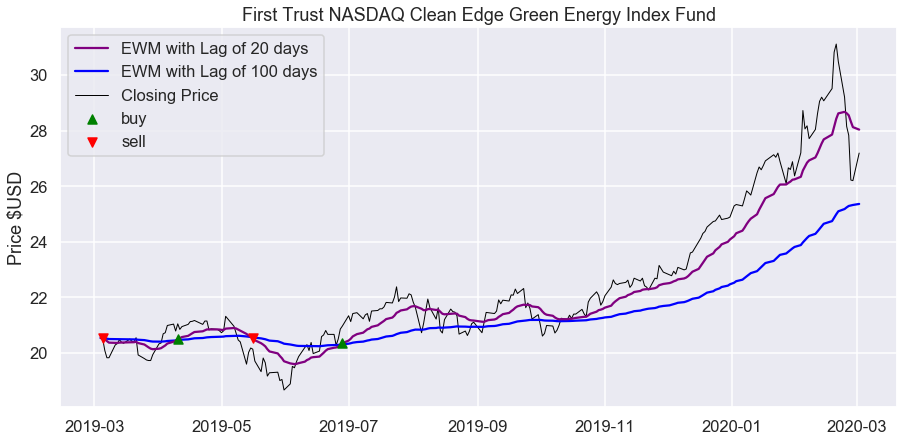

<Figure size 432x288 with 0 Axes>

In [22]:
warnings.filterwarnings("ignore")
%matplotlib inline

if crossings_ewm_2days.any() == False:    
    
    prev_ewm20d = ewm_20d['Close'].shift(1)
    prev_ewm100d = ewm_100d['Close'].shift(1)

    crossings_ewm = (((ewm_20d['Close'] <= ewm_100d['Close']) & (prev_ewm20d >= prev_ewm100d))
            | ((ewm_20d['Close'] >= ewm_100d['Close']) & (prev_ewm20d <= prev_ewm100d)))
    

# join sma_20d and stockp2 on index
    ewm20d_ewm100d = ewm_20d.join(ewm_100d, lsuffix='20dayEWM', rsuffix='100dayEWM')

# add a buy sell column based on the direction in which the stock price 
#crossed the moving average
    crossing_dates = ewm20d_ewm100d[crossings_ewm]
    crossing_dates['switch_sign'] = crossing_dates['Close20dayEWM'] - crossing_dates['Close100dayEWM']
    crossing_dates['buyorsell'] = np.where(crossing_dates['switch_sign'] > 0, 'buy', 'sell')

    buyewm_symbol = crossing_dates['buyorsell'] == 'buy'
    sellewm_symbol = crossing_dates['buyorsell'] == 'sell'

    buyewm_series = crossing_dates[buyewm_symbol]
    sellewm_series =crossing_dates[sellewm_symbol] 

    sns.set(style='darkgrid', context='talk', palette='Dark2')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.set_title('First Trust NASDAQ Clean Edge Green Energy Index Fund')
    ax.set_ylabel('Price $USD')
    ax.plot(ewm_20d.index, ewm_20d['Close'], label = 'EWM with Lag of 20 days', color = 'purple', zorder = 10)
    ax.plot(ewm_100d.index, ewm_100d['Close'], label = 'EWM with Lag of 100 days', color = 'blue', zorder = 5)
    ax.plot(df.index, df['Close'], label = 'Closing Price', color = 'black', linewidth = 1,  zorder = 1)
    
    ax.scatter(buyewm_series.index, buyewm_series['Close20dayEWM'], marker = "^", color = 'green', label = 'buy', zorder = 15 )
    ax.scatter(sellewm_series.index, sellewm_series['Close20dayEWM'], marker = "v", color = 'red', label = 'sell', zorder = 15)
    ax.legend()
    plt.show()

    
 # save the plot to be used as an email attachment
    today = date.today()
    d1 = today.strftime("%d-%m-%Y")
    figname = 'ewm-' + d1 + '.png'
    plt.savefig(figname)

In [ ]:
# retrieve email_address and email_password that are saved as
#environment variables on the user's computer

if crossings_ewm_2days.any() == False:
    email_address = os.environ.get('USER_EMAIL')
    email_password = os.environ.get('USER_PASSWORD')
    
       
# Create the list of email addresses from the email_address_list csv file
    email_df = pd.read_csv('email_address_list.csv')
    email_list = email_df.iloc[:,1].tolist()
    
    
# determine which message to send

    last_day = crossing_dates.index[-1].strftime("%d-%m-%Y")
    if crossing_dates.iloc[-1,3] == 'buy':
        message_content = 'The 20 day exponential moving average has crossed the 100 day exponential moving average positively on ' + last_day + '. This is a signal to invest in First Trust NASDAQ Clean Edge Green Energy Index Fund (QCLN)'
    else:
        message_content = 'The 100 day exponential moving average has crossed the 100 day exponential moving average negatively on ' + last_day + '. This is a signal to divest from First Trust NASDAQ Clean Edge Green Energy Index Fund (QCLN)'
    
    
    msg = EmailMessage()
    
    msg['Subject'] = 'NASDAQ Clean Edge Green Energy Index Fund (QCLN) Has Crossed The Moving Average'
    msg['From'] = email_address
    msg['To'] = email_list
    msg.set_content(message_content)
    
    with open(figname, 'rb') as f:
        file_data = f.read()
        file_type = imghdr.what(f.name)
        file_name = f.name
        
    msg.add_attachment(file_data, maintype = 'image', subtype = file_type, filename = file_name)
    
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(email_address, email_password)
        smtp.send_message(msg)

In [24]:
from IPython.display import Image
![title]("img/picture.png")

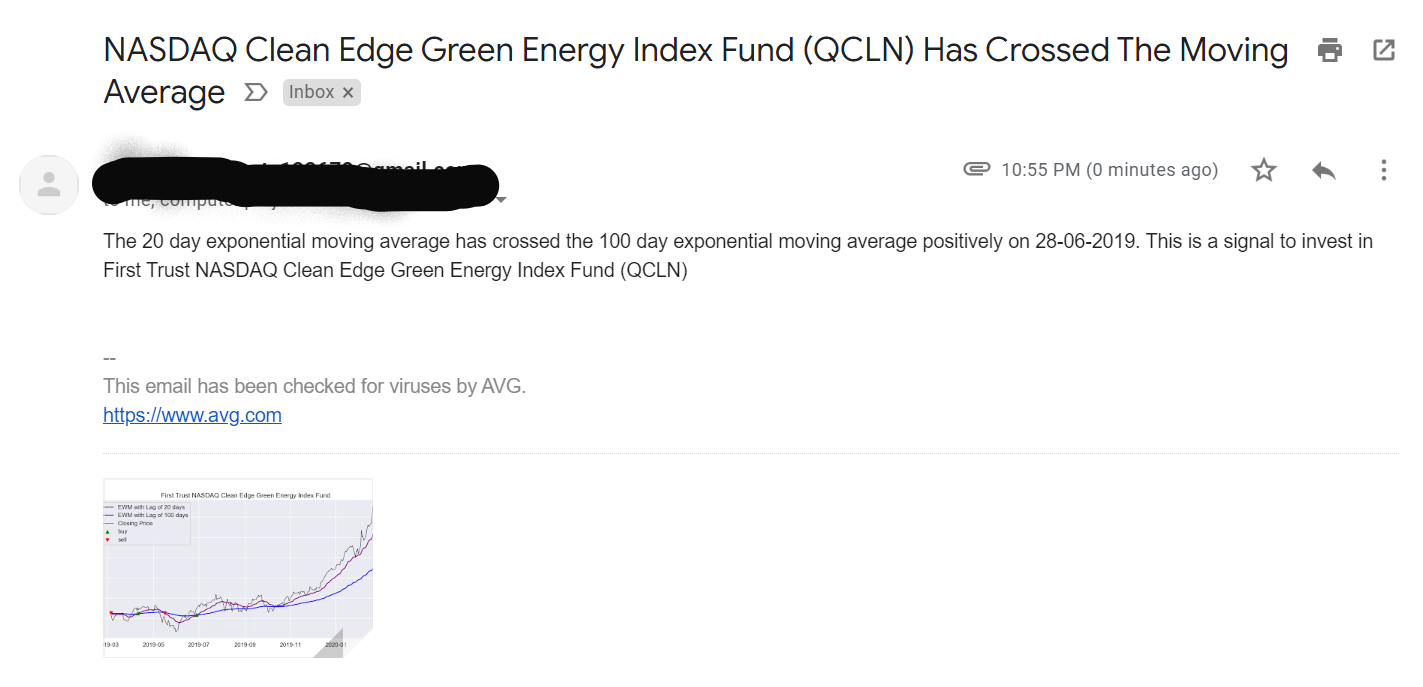

In [26]:
Image(filename = 'C:/Users/Sarah/Pictures/Camera Roll/email_notification.png')